<a href="https://colab.research.google.com/github/narsym/deep-learning-with-pytorch/blob/master/Data_Augmentation_and_ResNets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data

In [1]:
import os
import torch 
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
dataset_url = 'http://files.fast.ai/data/cifar10.tgz'
download_url(dataset_url, '.')

In [3]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path = './data')

In [4]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + '/train')
print(classes)

['test', 'labels.txt', 'train']
['airplane', 'deer', 'cat', 'truck', 'automobile', 'ship', 'bird', 'dog', 'frog', 'horse']


In [9]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [11]:
state = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding = 4, padding_mode = 'reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*state)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*state)])

In [15]:
train_ds = ImageFolder(data_dir + '/train', train_tfms)
valid_ds = ImageFolder(data_dir + '/test', valid_tfms)

In [13]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

batch_size = 256

In [16]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 8, pin_memory = True)

val_dl = DataLoader(valid_ds, batch_size, shuffle = True, num_workers = 8, pin_memory = True)

In [21]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images[:100], 10).permute(1, 2, 0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


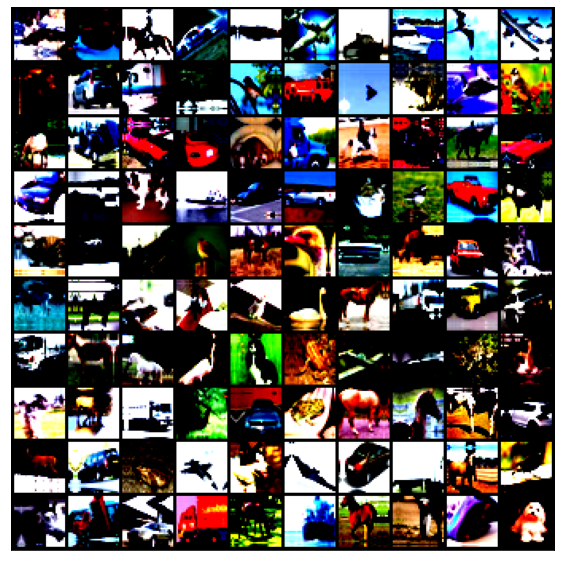

In [22]:
show_batch(train_dl)

#Model

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out + x)

In [25]:
simple_resnet = SimpleResidualBlock()

for images, labels in train_dl:
  out = simple_resnet(images)
  print(out.shape)
  break

torch.Size([256, 3, 32, 32])


In [39]:
def conv_2d(ni, nf, stride = 1, ks = 3):
  return nn.Conv2d(in_channels = ni, out_channels = nf, kernel_size = ks, stride = stride, padding = ks // 2, bias = False)

def bn_relu_conv(ni, nf):
  return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace = True), conv_2d(ni, nf))

class ResidualBlock(nn.Module):
  def __init__(self, ni, nf, stride = 1):
    super().__init__()
    self.bn = nn.BatchNorm2d(ni)
    self.conv1 = conv_2d(ni, nf, stride)
    self.conv2 = bn_relu_conv(nf, nf)
    self.shortcut = lambda x: x
    if ni != nf:
      self.shortcut = conv_2d(ni, nf, stride, 1)

  def forward(self, x):
    x = F.relu(self.bn(x), inplace = True)
    r = self.shortcut(x)
    x = self.conv1(x)
    x = self.conv2(x) * 0.2
    return x.add_(r)

In [44]:
def make_group(N, ni, nf, stride):
  start = ResidualBlock(ni, nf, stride)
  rest = [ResidualBlock(nf, nf) for j in range(1, N)]
  return [start] + rest

class Flatten(nn.Module):

  def __init__(self): super().__init__()

  def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
  def __init__(self, n_groups, N, n_classes, k = 1, n_start = 16):
    super().__init__()

    layers = [conv_2d(3, n_start)]
    n_channels = [n_start]

    for i in range(n_groups):
      n_channels.append(n_start * (2 ** i) * k)
      stride = 2 if i > 0 else 1
      layers += make_group(N, n_channels[i], n_channels[i + 1], stride)

    layers += [nn.BatchNorm2d(
        n_channels[3]),
        nn.ReLU(inplace = True),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(n_channels[3], n_classes)]

    self.features = nn.Sequential(*layers)
  
  def forward(self, x): return self.features(x)

def wrn_22():
  return WideResNet(n_groups = 3, N = 3, n_classes = 10, k = 6)


In [45]:
model = wrn_22()

In [46]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [47]:
for images, labels, in train_dl:
  print('images.shape', images.shape)
  out = model(images)
  print('out.shape:', out.shape)
  break

images.shape torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])


#Training

In [48]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [51]:
data = DataBunch.create(train_ds, valid_ds, bs = batch_size, path = './data/cifar10')
learner = Learner(data, model, loss_func = F.cross_entropy, metrics = [accuracy])
learner.clip = 0.1

In [52]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


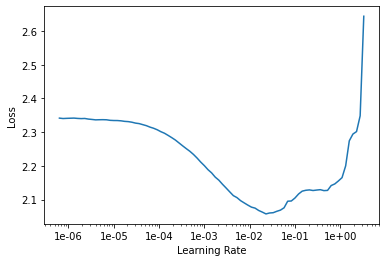

In [53]:
learner.recorder.plot()

In [54]:
learner.fit_one_cycle(9, 5e-3, wd = 1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.270917,1.295452,0.541900,01:37
1,0.926586,1.858204,0.537600,01:37
2,0.711728,0.889350,0.707800,01:37
3,0.564094,0.625013,0.791800,01:37
4,0.447240,0.465750,0.840800,01:37
5,0.358142,0.396728,0.865500,01:37
6,0.266115,0.330079,0.891700,01:36
7,0.199837,0.270555,0.908600,01:37
8,0.170774,0.267059,0.912000,01:37


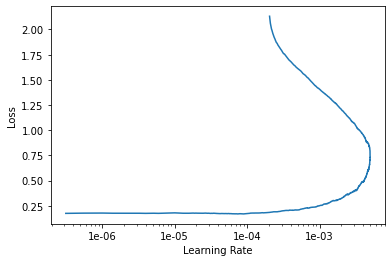

In [55]:
learner.recorder.plot()

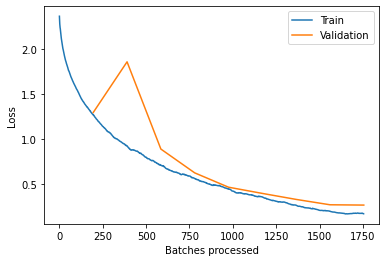

In [56]:
learner.recorder.plot_losses()

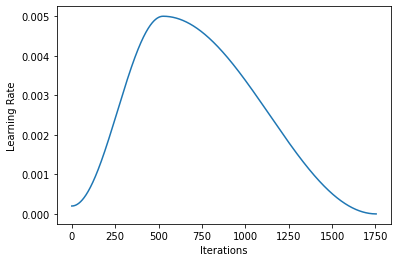

In [57]:
learner.recorder.plot_lr()

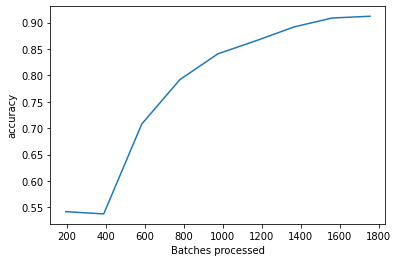

In [58]:
learner.recorder.plot_metrics()

In [59]:
torch.save(model.state_dict(), 'cifar10-wrn22.pth')